In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from tqdm import tqdm
import matplotlib.colors as mcolors
from copy import deepcopy
from gudhi.representations import Landscape, PersistenceImage

from topofisher.input_simulators.noisy_ring import CircleSimulator

from topofisher.filtrations.numpy.alphaDTML import AlphaDTMLayer

from topofisher.vectorizations.numpy.custom_vectorizations import TOPK
from topofisher.vectorizations.numpy.vectorization_layer import VectorizationLayers
from topofisher.vectorizations.numpy.shorthand_layers import PersistenceImages, PersistenceLandscapes

from topofisher.fisher.Fisher import show_fm_and_bias, fisherFromVecs, fisherMOPED
from topofisher.fisher.imnn import IMNNLayer, MopedLayer, ExtraDimLayer, FisherLayer
from topofisher.fisher.plot_fisher_stats import plotContours2D, plotSummaryDerivativeHists, plot_derivative_convergence


from topofisher.pipelines.circle import CirclePipeline
from topofisher.pipelines.convergence_checks import fisher_estimates_wrt_step_size
from topofisher.pipelines.utils import readFromFile, writeToFile

import CompressedFisher

2023-11-03 20:09:02.293382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-03 20:09:09.642062: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Importlib

In [10]:
import importlib
import topofisher
importlib.reload(topofisher.fisher.Fisher)
importlib.reload(topofisher.fisher.imnn)

importlib.reload(topofisher.filtrations.numpy.filtration_layers)
importlib.reload(topofisher.filtrations.numpy.alphaDTML)
importlib.reload(topofisher.input_simulators.noisy_ring)
importlib.reload(topofisher.pipelines.pipeline)
importlib.reload(topofisher.pipelines.circle)

from topofisher.input_simulators.noisy_ring import CircleSimulator

from topofisher.filtrations.numpy.alphaDTML import AlphaDTMLayer

from topofisher.vectorizations.numpy.custom_vectorizations import TOPK
from topofisher.vectorizations.numpy.vectorization_layer import VectorizationLayers
from topofisher.vectorizations.numpy.shorthand_layers import PersistenceImages, PersistenceLandscapes
importlib.reload(topofisher.fisher.Fisher)
from topofisher.fisher.Fisher import show_fm_and_bias, fisherFromVecs, fisherMOPED
importlib.reload(topofisher.fisher.imnn)
from topofisher.fisher.imnn import IMNNLayer, FisherLayer, MopedLayer, ExtraDimLayer
from topofisher.fisher.plot_fisher_stats import plotContours2D, plotSummaryDerivativeHists, plot_derivative_convergence


from topofisher.pipelines.circle import CirclePipeline

## Starters

In [3]:
circle_pipeline = readFromFile("/Users/karthikviswanathan/Downloads/circle_pipelines/pipeline_m_p9_ns_4K.pkl")
fisher = circle_pipeline.fisher
show_fm_and_bias(fisher)

log FI =  16.77
FM =  [3830.37  539.6   539.6  5088.21]
Fractional bias =  [0.   0.03]
Constraints =  [0.01627976 0.01412493]


In [4]:
fish = fisherFromVecs(circle_pipeline.all_vecs, circle_pipeline.delta_theta)
show_fm_and_bias(fish)

log FI =  16.76
FM =  [3836.88  502.35  502.35 5025.35]
Fractional bias =  [0. 0.]
Constraints =  [0.01625069 0.01419965]


In [5]:
fish = fisherMOPED(circle_pipeline.all_vecs, circle_pipeline.delta_theta)
show_fm_and_bias(fish)

log FI =  16.77
FM =  [3824.63  538.79  538.79 5080.57]
Fractional bias =  [0. 0.]
Constraints =  [0.01629199 0.01413554]


In [6]:
np.linalg.inv(fish.ders), fish.C

(array([[ 2.62099900e-04, -2.49779319e-05],
        [-2.51109281e-05,  2.04798006e-04]]),
 <tf.Tensor: shape=(2, 2), dtype=float64, numpy=
 array([[3897.59887272,  406.58479541],
        [ 406.58479541, 4805.21502824]])>)

In [7]:
vectorizations = [TOPK(bdp_type = "bdp", is_binned = False, topk = 219), TOPK(bdp_type = "bdp", is_binned = False, topk = 29)]

vecLayer = VectorizationLayers(vectorizations = vectorizations[1:], pds_idx_list = [1])
fisherLayer = FisherLayer()
fish = circle_pipeline.vectorize_and_fisher(vecLayer, fisherLayer)
show_fm_and_bias(fish)

log FI =  14.88
FM =  [2383.8    11.1    11.1  1220.21]
Fractional bias =  [0.   0.07]
Constraints =  [0.0204821  0.02862803]


In [8]:
circle_pipeline.collect_benchmarks()
TFM = circle_pipeline.benchmarks['TFM']
FM = fish.FM
(np.linalg.inv(TFM) - np.linalg.inv(FM))/np.linalg.inv(TFM)

array([[-7.90464316e-01,  1.43296403e+03],
       [ 1.43296403e+03, -4.69190358e+00]])

## Comparing VK and compressed fisher 

In [2]:
vectorizations = [TOPK(bdp_type = "bd", is_binned = True, topk = 219, num_bins = 25), TOPK(bdp_type = "bd", is_binned = True, topk = 29, num_bins = 5)]

vecLayer = VectorizationLayers(vectorizations = vectorizations)
fisherLayer = MopedLayer()
circle_pipeline = CirclePipeline(ncirc= 200, nback = 20, bgmAvg = 1., n_s = 4000, n_d = 4000, \
                                 theta_fid = tf.constant([1., 0.2]), delta_theta = tf.constant([0.1, 0.02]),\
                                 filtLayer = AlphaDTMLayer(m = 0.9, max_hom_dim = 2, hom_dim_list = [0, 1], show_tqdm = True),
                                 vecLayer = vecLayer, fisherLayer = fisherLayer, find_derivative = [True, True])
circle_pipeline.run_pipeline()

100%|██████████| 4000/4000 [00:32<00:00, 121.90it/s]


## Unbinned

In [3]:
vectorizations = [TOPK(bdp_type = "bp", is_binned = False, topk = 219), \
                  TOPK(bdp_type = "bp", is_binned = False, topk = 29)
                 ]

vecLayer = VectorizationLayers(vectorizations = vectorizations, pds_idx_list = [0, 1])
fisherLayer = FisherLayer()
fish = circle_pipeline.vectorize_and_fisher(vecLayer, fisherLayer)
show_fm_and_bias(fish)
summaries = fish.summaries

log FI =  16.88
FM =  [4019.86  382.68  382.68 5380.56]
Fractional bias =  [0.01 0.08]
Constraints =  [0.01582595 0.01367923]


In [14]:
summaries[0].shape

TensorShape([4000, 496])

In [33]:
import importlib
importlib.reload(CompressedFisher)

<module 'CompressedFisher' from '/Users/karthikviswanathan/opt/anaconda3/envs/newEnvbkup/lib/python3.8/site-packages/CompressedFisher/__init__.py'>

### Standard forecast

In [ ]:
fid_arr = summaries[0].numpy()
der_arr = summaries[1:]
params_fid = np.array(circle_pipeline.theta_fid)
delta_params =  0.5*np.array(circle_pipeline.delta_theta) 
parameter_names = ["radius", "sigma "]

dict_param_steps = {parameter_names[i]:delta_params[i] for i in range(len(params_fid))}
dict_deriv_sims = {parameter_names[i]:np.array(der_arr[2*i: 2*i + 2]) for i in range(len(params_fid))}
nSimsCovMat = fid_arr.shape[0]
nSims_deriv = der_arr[0].shape[0]
cFisher = CompressedFisher.gaussianFisher(parameter_names, nSims_deriv, \
                                          include_covmat_param_depedence=False,
                                      deriv_finite_dif_accuracy=2)
compress_frac_split_ders = 0.
compress_frac_split_cov = 0.
covmat_sims = fid_arr
cFisher.initailize_covmat(covmat_sims, True)
cFisher.initailize_mean(covmat_sims)
cFisher.initailize_deriv_sims(dic_deriv_sims=dict_deriv_sims, dict_param_steps=dict_param_steps)
cFisher.generate_deriv_sim_splits(compress_fraction=compress_frac_split_ders)
stnd_constraint    = cFisher.compute_fisher_forecast(parameter_names)
stnd_constraint_bias = cFisher.est_fisher_forecast_bias(parameter_names)
# print(cFisher._compute_fisher_matrix(parameter_names))
print(f'Parameter  \t standard Fisher \t Est. Fractional bias ')
for i,name in enumerate(parameter_names):
    print(f'{name}  \t\t  {stnd_constraint[i,i]**.5:.3f} \t\t     {(stnd_constraint_bias/stnd_constraint)[i,i]:.3f} ')

cFisher._compute_fisher_matrix(parameter_names)

In [7]:
fisherFromVecs(summaries, circle_pipeline.delta_theta).FM.numpy()

array([[3923.63959811,  462.75388314],
       [ 462.75388314, 5574.52774248]])

### Compressed Forecast

In [23]:
import importlib,topofisher
importlib.reload(CompressedFisher.fisher)
importlib.reload(CompressedFisher)
import CompressedFisher
from CompressedFisher import gaussianFisher
importlib.reload(topofisher.fisher.Fisher)
from topofisher.fisher.Fisher import show_fm_and_bias, fisherFromVecs, fisherMOPED
from topofisher.fisher.imnn import IMNNLayer, MopedLayer, ExtraDimLayer, FisherLayer



In [156]:
fid_arr = summaries[0].numpy()
der_arr = summaries[1:]
params_fid = np.array(circle_pipeline.theta_fid)
delta_params =  0.5*np.array(circle_pipeline.delta_theta) 
parameter_names = ["radius", "sigma "]

dict_param_steps = {parameter_names[i]:delta_params[i] for i in range(len(params_fid))}
dict_deriv_sims = {parameter_names[i]:der_arr[2*i: 2*i + 2].numpy() for i in range(len(params_fid))}
nSimsCovMat = fid_arr.shape[0]
nSims_deriv = der_arr.shape[1]
cFisher = CompressedFisher.gaussianFisher(parameter_names, nSims_deriv, \
                                          include_covmat_param_depedence=False,
                                      deriv_finite_dif_accuracy=2)
compress_frac_split_ders = 0.5
compress_frac_split_cov = 0.5

covmat_sims = fid_arr
cFisher.initailize_covmat(covmat_sims, True)
cFisher.params_names = parameter_names
def find_fm_cf(): 
    #cFisher.generate_covmat_sim_splits(compress_fraction = compress_frac_split_cov)
    
    cFisher.generate_covmat_sim_splits(ids_comp = list(range(0, nSimsCovMat//2)), \
                                       ids_fish = list(range(nSimsCovMat//2, nSimsCovMat)))

    # print(cFisher.covmat_comp)
    cFisher.initailize_mean(covmat_sims)
    cFisher.initailize_deriv_sims(dic_deriv_sims=dict_deriv_sims, dict_param_steps=dict_param_steps)
    cFisher.generate_deriv_sim_splits(ids_comp = list(range(0, nSims_deriv//2)), \
              ids_fish = list(range(nSims_deriv//2, nSims_deriv)))

    # cFisher.generate_deriv_sim_splits(compress_fraction = compress_frac_split_ders)

    return cFisher
    # return 

In [183]:
import tensorflow_probability as tfp
class fisherMOPED(fisherFromVecs):
    """
    Fisher analysis after compression using MOPED given the summaries 
    calculated at 
    [theta_fid, ..., (theta_fid - delta_theta/2)_i, \
     (theta_fid + delta_theta/2)_i, ...]. One half of the simulations is used 
    to estimate the MOPED compression matrix and the other half is used to 
    carry out the Fisher analysis of the compressed summaries. 
    """
    def __init__(self, summaries, delta_theta, name = "MOPED", \
                 clean_data = True):
        """
        Initialize a MOPED Fisher class.
        
        Parameters
        ----------
        summaries : tf.Tensor
            Summaries for constructing the compression matrix (training) and
            for the Fisher analysis (testing).
        delta_theta : tf.Tensor
            The step size that is used to calculate the derivatives.
        name : str, optional
            Name for the Fisher class. The default is None.
        clean_data : bool, optional
            Flag to clean data. If True, removes columns with zero variance.
            The default is True.
        """
        n_s = summaries[0].shape[0]
        n_d = summaries[1].shape[0]
        
        self.delta_theta = delta_theta
        self._n_params = (len(summaries) - 1)//2 # Subtracting 1 for fiducial
        
        # shuffled_summaries = self.shuffle_data_vectors(summaries)
        shuffled_summaries = summaries
        vecs_cov = shuffled_summaries[0][ :n_s//2]
        der_vecs = [item[ :n_d//2] for item in shuffled_summaries[1:]]
        
        self.moped_compmat = self.compute_compression_matrix(vecs_cov, der_vecs)
        print(self.moped_compmat.shape)
        
        fisher_vecs = [shuffled_summaries[0][n_s//2: ]]
        fisher_vecs.extend([item[n_d//2: ] for item in shuffled_summaries[1:]])

        compressed_vecs = [tf.matmul(item, self.moped_compmat) \
                           for item in fisher_vecs] 
        super().__init__(compressed_vecs, delta_theta, name, clean_data)
    
    def shuffle_data_vectors(self, summaries):
        seeds = np.random.randint(1e6, size = 1 + self._n_params)
        shuffled_summaries = []
        for idx in range(1 + 2*self._n_params):
            arr = shuffle_with_seed(summaries[idx], seeds[(1 + idx)//2])
            shuffled_summaries.append(arr)
        return shuffled_summaries
    
    def compute_compression_matrix(self, vecs_cov, der_vecs):
        derivatives = computeDerivatives(tf.stack(der_vecs), self.delta_theta)    
        ders = tf.math.reduce_mean(derivatives, axis = 1)
        moped_covariance = computeCovariance(vecs_cov)
        self.moped_covariance = moped_covariance
        moped_compmat = \
            tf.linalg.solve(moped_covariance, tf.transpose(ders))
        return moped_compmat
    
def shuffle_with_seed(arr, seed):
    # print(seed)
    np.random.seed(seed)
    indices = np.random.permutation(arr.shape[0])
    return tf.gather(arr, indices)

def computeCovariance(vecs_cov):
    cov = tfp.stats.covariance(vecs_cov)
    n_sims_covmat, dim = tf.cast(tf.shape(vecs_cov)[0], cov.dtype), \
        tf.cast(tf.shape(vecs_cov)[1], cov.dtype)
    hartlap_fisher = tf.cast((n_sims_covmat - dim - 2.)/(n_sims_covmat - 1),\
                             dtype = cov.dtype)
    return cov/hartlap_fisher   


def computeDerivatives(der_vecs, delta_theta):
    delta_theta_cast = tf.cast(delta_theta[:, tf.newaxis, tf.newaxis], \
                               der_vecs.dtype)
    return (der_vecs[1::2] - der_vecs[::2])/delta_theta_cast 

In [184]:
cFisher = find_fm_cf()
moped_fish = fisherMOPED(summaries, circle_pipeline.delta_theta)

(496, 2)


In [189]:
n_sims_covmat, dim = 2000, 496
hartlap_fisher = tf.cast((n_sims_covmat - dim - 2.)/(n_sims_covmat ),\
                         dtype = tf.float64)
(cFisher.covmat_comp - moped_fish.moped_covariance/hartlap_fisher) / cFisher.covmat_comp

<tf.Tensor: shape=(496, 496), dtype=float64, numpy=
array([[-0.77216001, -0.77216001, -0.77216001, ..., -0.77216001,
        -0.77216001, -0.77216001],
       [-0.77216001, -0.77216001, -0.77216001, ..., -0.77216001,
        -0.77216001, -0.77216001],
       [-0.77216001, -0.77216001, -0.77216001, ..., -0.77216001,
        -0.77216001, -0.77216001],
       ...,
       [-0.77216001, -0.77216001, -0.77216001, ..., -0.77216001,
        -0.77216001, -0.77216001],
       [-0.77216001, -0.77216001, -0.77216001, ..., -0.77216001,
        -0.77216001, -0.77216001],
       [-0.77216001, -0.77216001, -0.77216001, ..., -0.77216001,
        -0.77216001, -0.77216001]])>

In [182]:
h = np.random.normal(size=[10,4]) 
print(np.cov(h.T, ddof=0)) 
print(tfp.stats.covariance(h))

[[ 0.72091415 -0.12957238 -0.19769256 -0.15267807]
 [-0.12957238  0.94657723  0.27625766 -0.42589785]
 [-0.19769256  0.27625766  0.63120559  0.043043  ]
 [-0.15267807 -0.42589785  0.043043    0.59661893]]
tf.Tensor(
[[ 0.72091415 -0.12957238 -0.19769256 -0.15267807]
 [-0.12957238  0.94657723  0.27625766 -0.42589785]
 [-0.19769256  0.27625766  0.63120559  0.043043  ]
 [-0.15267807 -0.42589785  0.043043    0.59661893]], shape=(4, 4), dtype=float64)


In [ ]:
(cFisher._compress_mean_only(np.identity(fid_arr.shape[1])) - moped_fish.moped_compmat.numpy())/moped_fish.moped_compmat

In [187]:
cFisher._compute_compressed_fisher_matrix()

array([[2992.11181141,  183.15600152],
       [ 183.15600152, 3162.99024476]])

In [188]:
moped_fish.FM

<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
array([[2991.36003751,  183.10998322],
       [ 183.10998322, 3162.19553733]])>

In [ ]:
lis = []
for _ in tqdm(range(100)):
    moped_fish = fisherMOPED(summaries, circle_pipeline.delta_theta)
    fm = moped_fish.FM.numpy().flatten()
    lis.append(fm)
lis = np.array(lis)

lis_cf = []
for _ in tqdm(range(100)):
    fm = find_fm_cf()
    lis_cf.append(fm.flatten())
lis_cf = np.array(lis_cf)


    
    
    

In [ ]:
plt.hist(lis[:, num])

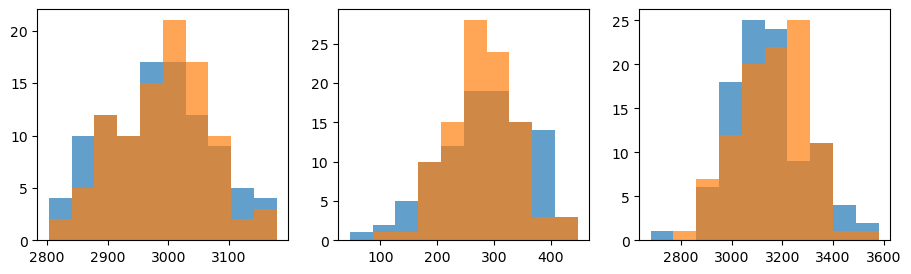

In [143]:
ncols = 3
fig, axes = plt.subplots(nrows=1, ncols= ncols, figsize=(3 * ncols + 2 , 3))
for idx, num in enumerate([0, 1, 3]):
    val, bins, _ = axes[idx].hist(lis[:, num], alpha = 0.7)
    axes[idx].hist(lis_cf[:, num], alpha = 0.7, bins = bins)

In [121]:
moped_fish = fisherMOPED(summaries, circle_pipeline.delta_theta)
moped_fish.FM

<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
array([[2978.80339249,  251.3917492 ],
       [ 251.3917492 , 2813.41747229]])>

<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
array([[2863.13100583,  260.67257319],
       [ 260.67257319, 3173.33061725]])>

array([[3132.67719025,  302.17611   ],
       [ 302.17611   , 3037.80188827]])

<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
array([[3073.18317089,  448.40871146],
       [ 448.40871146, 2794.75638564]])>

## Binned

In [3]:
vectorizations = [TOPK(bdp_type = "bp", is_binned = True, num_bins = 108, topk = 219), \
                  TOPK(bdp_type = "bp", is_binned = False, topk = 29)
                 ]

vecLayer = VectorizationLayers(vectorizations = vectorizations, pds_idx_list = [0, 1])
fisherLayer = FisherLayer()
fish = circle_pipeline.vectorize_and_fisher(vecLayer, fisherLayer)
show_fm_and_bias(fish)

log FI =  16.85
FM =  [3678.88  486.72  486.72 5710.1 ]
Fractional bias =  [0.01 0.15]
Constraints =  [0.01658078 0.01330886]


In [12]:
vectorizations = [TOPK(bdp_type = "bp", is_binned = True, num_bins = 25, topk = 219), \
                  TOPK(bdp_type = "bp", is_binned = True, num_bins = 5, topk = 29)
                 ]

vecLayer = VectorizationLayers(vectorizations = vectorizations, pds_idx_list = [0, 1])
fisherLayer = MopedLayer()
fish = circle_pipeline.vectorize_and_fisher(vecLayer, fisherLayer)
show_fm_and_bias(fish)

log FI =  16.2
FM =  [3092.69  538.44  538.44 3596.12]
Fractional bias =  [0.   0.01]
Constraints =  [0.01822079 0.01689735]


In [ ]:
fid_arr = fish.summaries[0].numpy()
der_arr = fish.summaries[1:]
params_fid = np.array(circle_pipeline.theta_fid)
delta_params =  0.5*np.array(circle_pipeline.delta_theta) 
parameter_names = ["radius", "sigma "]

dict_param_steps = {parameter_names[i]:delta_params[i] for i in range(len(params_fid))}
dict_deriv_sims = {parameter_names[i]:der_arr[2*i: 2*i + 2].numpy() for i in range(len(params_fid))}
nSimsCovMat = fid_arr.shape[0]
nSims_deriv = der_arr.shape[1]
cFisher = CompressedFisher.gaussianFisher(parameter_names, nSims_deriv, \
                                          include_covmat_param_depedence=False,
                                      deriv_finite_dif_accuracy=2)
compress_frac_split_ders = 0.
compress_frac_split_cov = 0.
covmat_sims = fid_arr
cFisher.initailize_covmat(covmat_sims, True)
cFisher.initailize_mean(covmat_sims)
cFisher.initailize_deriv_sims(dic_deriv_sims=dict_deriv_sims, dict_param_steps=dict_param_steps)
cFisher.generate_deriv_sim_splits(compress_fraction=compress_frac_split_ders)
stnd_constraint    = cFisher.compute_fisher_forecast(parameter_names)
stnd_constraint_bias = cFisher.est_fisher_forecast_bias(parameter_names)
# print(cFisher._compute_fisher_matrix(parameter_names))
print(f'Parameter  \t standard Fisher \t Est. Fractional bias ')
for i,name in enumerate(parameter_names):
    print(f'{name}  \t\t  {stnd_constraint[i,i]**.5:.3f} \t\t     {(stnd_constraint_bias/stnd_constraint)[i,i]:.3f} ')

cFisher._compute_fisher_matrix(parameter_names)

In [ ]:
cFisher._compute_fisher_matrix(parameter_names)

In [ ]:
cFisher._compute_combined_fisher_matrix(parameter_names)

In [ ]:
cFisher._compute_compressed_fisher_matrix(parameter_names)

### Rough

In [ ]:
moped_fish.err,  cFisher._compute_compressed_fisher_matrix_error(["radius", "sigma "])

In [ ]:
cFisher._compute_fisher_matrix_error(["radius", "sigma "])

In [ ]:
params_names = parameter_names
dim_fisher = len(params_names)
compressed_derivs = np.zeros([dim_fisher,cFisher._n_params])

for i,n in enumerate(params_names):
    compressed_derivs[i]=cFisher.compress_vector(cFisher.deriv_mean_fisher[n],with_mean=False)

compressed_covmat = cFisher.compress_vector(cFisher.covmat_fisher,with_mean=False)
compressed_covmat = cFisher.compress_vector(compressed_covmat.T,with_mean=False)/cFisher._hartlap_comp # One factor cancels here as we have C^{-1}C C^{-1} 


In [ ]:
cFisher._covmat_comp

In [ ]:
cFisher._hartlap_comp

In [ ]:
cFisher._hartlap_fisher

In [ ]:
np.cov(cFisher.compress_vector(cFisher._covmat_sims).T)/compressed_covmat

In [ ]:
moped_fish.C

In [ ]:
compressed_covmat/moped_fish.C

In [ ]:
np.array([compressed_derivs[0], compressed_derivs[1]])/moped_fish.ders

In [ ]:
cFisher._compute_compressed_fisher_matrix(parameter_names)

In [ ]:
moped_fish = fisherMOPED(fish.summaries, fish.delta_theta)
moped_fish.FM/cFisher._compute_compressed_fisher_matrix(parameter_names)

In [ ]:
moped_fish.err

In [ ]:
import topofisher
moped_fish_old = fisherMOPEDOld(fish.summaries, fish.delta_theta)
moped_fish_old.FM

In [ ]:
np.max(np.abs((fish.C - cFisher.covmat_fisher/cFisher._hartlap_fisher)/fish.C))

In [ ]:
cFisher._deriv_sim_ids

In [ ]:
cFisher._hartlap_fisher

In [ ]:
cFisher.ders@np.linalg.solve(fish.C, cFisher.ders.T)

In [ ]:
cFisher.ders@np.linalg.solve(cFisher.covmat_fisher, cFisher.ders.T)

In [ ]:
cFisher.ders@fish.invC@ cFisher.ders.T*cFisher._hartlap_fisher

In [ ]:
cFisher.ders = np.stack([cFisher.deriv_mean_fisher['radius'], cFisher.deriv_mean_fisher['sigma ']]) 

In [ ]:
np.argmax(np.abs((fish.ders - cFisher.ders)/cFisher.ders)[0])

In [ ]:
fish.ders[0, 221]

In [ ]:
fish.ders[0, 221].numpy(), cFisher.ders[0, 221]

In [ ]:
list(range(1, 20))

In [ ]:
compress_frac_split = 0.5
fid_arr = fish.summaries[0].numpy()
der_arr = fish.summaries[1:]
params_fid = np.array(circle_pipeline.theta_fid)
delta_params =  0.5*np.array(circle_pipeline.delta_theta) 
parameter_names = ["radius", "sigma "]

dict_param_steps = {parameter_names[i]:delta_params[i] for i in range(len(params_fid))}
dict_deriv_sims = {parameter_names[i]:der_arr[2*i: 2*i + 2].numpy() for i in range(len(params_fid))}
nSimsCovMat = fid_arr.shape[0]
nSims_deriv = der_arr.shape[1]
cFisher = CompressedFisher.gaussianFisher(parameter_names, nSims_deriv, \
                                          include_covmat_param_depedence=False,
                                      deriv_finite_dif_accuracy=2)
covmat_sims = fid_arr
cFisher.initailize_covmat(covmat_sims)
cFisher.initailize_mean(covmat_sims)
cFisher.initailize_deriv_sims(dic_deriv_sims=dict_deriv_sims, dict_param_steps=dict_param_steps)
cFisher.generate_deriv_sim_splits(ids_fish = list(range(2000, 4000)) , ids_comp = list(range(2000)))
stnd_constraint    = cFisher.compute_fisher_forecast(parameter_names)
stnd_constraint_bias = cFisher.est_fisher_forecast_bias(parameter_names)
print(cFisher._compute_fisher_matrix(parameter_names))
print(f'Parameter  \t standard Fisher \t Est. Fractional bias ')
for i,name in enumerate(parameter_names):
    print(f'{name}  \t\t  {stnd_constraint[i,i]**.5:.3f} \t\t     {(stnd_constraint_bias/stnd_constraint)[i,i]:.3f} ')

compressed_constraint = cFisher.compute_compressed_fisher_forecast(parameter_names)
compressed_constraint_bias = cFisher.est_compressed_fisher_forecast_bias(parameter_names)

print(f'Parameter \t Compressed Fisher \t Est. Fractional bias ')
for i,name in enumerate(parameter_names):
    print(f'{name}   \t\t  {compressed_constraint[i,i]**.5:.3f} \t\t   \
    {(compressed_constraint_bias/compressed_constraint)[i,i]:.3f} ')


combined_constraint = cFisher.compute_combined_fisher_forecast(parameter_names)
# print(f'Parameter  standard Fisher  Bias compressed comp Bias combined ')
print(f'Parameter \t Combined Fisher  ')
for i,name in enumerate(parameter_names):
    print(f'{name}   \t\t  {combined_constraint[i,i]**.5:.3f}')


In [ ]:
cFisher._compute_compressed_fisher_matrix(parameter_names)

In [ ]:
def compute_compressed_fisher_matrix_mean_only_error(params_names):
    """
    The function to compute the bias to the compressed Fisher matrix for the case of a parameter independent covariance matrix.
    This is computed with Eq. 11 in Coulton and Wandelt.

    Args:
        params_names ([list]): The list of parameters to include in the forecast. If none all parameters will be used (default: `None`)

    Returns:
        [n_parameter x n_parameter matrix]: The bias to the Fisher information.
    """
    n_params = len(params_names)


    derivs_covMat = cFisher._compute_deriv_mu_covmat(params_names)

    compressed_covmat = cFisher.compress_vector(cFisher.covmat_fisher,with_mean=False)
    compressed_covmat = cFisher.compress_vector(compressed_covmat.T,with_mean=False)
    
    return derivs_covMat
    mix_matrix =  np.zeros([n_params,n_params,cFisher._n_params,cFisher._n_params])
    for i in range(n_params):
        for j in range(i+1):
            tmp_mat = cFisher.compress_vector(derivs_covMat[i,j],with_mean=False)
            mix_matrix[i,j] = mix_matrix[j,i] = cFisher.compress_vector(tmp_mat.T,with_mean=False)
    fisher_err = np.zeros([n_params,n_params])
    for i in range(n_params):
        for j in range(i+1):
            fisher_err[i,j] = fisher_err[j,i] = np.trace(np.linalg.solve(compressed_covmat,mix_matrix[i,j]))
    return fisher_err

compute_compressed_fisher_matrix_mean_only_error(cFisher.param_names)

In [ ]:
moped_fish = fisherMOPED(fish.summaries, fish.delta_theta)

In [ ]:
moped_fish.FM.numpy()

In [ ]:
moped_fish.C.numpy(), moped_fish.ders.numpy()

In [ ]:
moped_fish.fractional_bias

In [ ]:
ind = np.random.randint(496)
plt.hist(fid_arr[:, ind], bins = 60)
plt.title(str(ind))
plt.show()

In [ ]:
fid_arr = fish.summaries[0].numpy()
der_arr = fish.summaries[1:]
params_fid = np.array(circle_pipeline.theta_fid)
delta_params =  0.5*np.array(circle_pipeline.delta_theta) 
parameter_names = ["radius", "sigma "]

dict_param_steps = {parameter_names[i]:delta_params[i] for i in range(len(params_fid))}
dict_deriv_sims = {parameter_names[i]:der_arr[2*i: 2*i + 2].numpy() for i in range(len(params_fid))}
nSimsCovMat = fid_arr.shape[0]
nSims_deriv = der_arr.shape[1]
cFisher = CompressedFisher.gaussianFisher(parameter_names, nSims_deriv, \
                                          include_covmat_param_depedence=False,
                                      deriv_finite_dif_accuracy=2)
compress_frac_split_ders = 0.5
compress_frac_split_cov = 0.5
covmat_sims = fid_arr
cFisher.initailize_covmat(covmat_sims, True)
cFisher.initailize_mean(covmat_sims)
cFisher.initailize_deriv_sims(dic_deriv_sims=dict_deriv_sims, dict_param_steps=dict_param_steps)
cFisher.generate_deriv_sim_splits(compress_fraction=compress_frac_split_ders)
cFisher.generate_covmat_sim_splits(compress_fraction=compress_frac_split_cov)
stnd_constraint    = cFisher.compute_fisher_forecast(parameter_names)
stnd_constraint_bias = cFisher.est_fisher_forecast_bias(parameter_names)
# print(cFisher._compute_fisher_matrix(parameter_names))
print(f'Parameter  \t standard Fisher \t Est. Fractional bias ')
for i,name in enumerate(parameter_names):
    print(f'{name}  \t\t  {stnd_constraint[i,i]**.5:.3f} \t\t     {(stnd_constraint_bias/stnd_constraint)[i,i]:.3f} ')

compressed_constraint = cFisher.compute_compressed_fisher_forecast(parameter_names)
compressed_constraint_bias = cFisher.est_compressed_fisher_forecast_bias(parameter_names)

print(f'Parameter \t Compressed Fisher \t Est. Fractional bias ')
for i,name in enumerate(parameter_names):
    print(f'{name}   \t\t  {compressed_constraint[i,i]**.5:.3f} \t\t   \
    {(compressed_constraint_bias/compressed_constraint)[i,i]:.3f} ')


combined_constraint = cFisher.compute_combined_fisher_forecast(parameter_names)
# print(f'Parameter  standard Fisher  Bias compressed comp Bias combined ')
print(f'Parameter \t Combined Fisher  ')
for i,name in enumerate(parameter_names):
    print(f'{name}   \t\t  {combined_constraint[i,i]**.5:.3f}')


In [ ]:
fid_arr = fish.summaries[0].numpy()
der_arr = fish.summaries[1:]
params_fid = np.array(circle_pipeline.theta_fid)
delta_params =  0.5*np.array(circle_pipeline.delta_theta) 
parameter_names = ["radius", "sigma "]

dict_param_steps = {parameter_names[i]:delta_params[i] for i in range(len(params_fid))}
dict_deriv_sims = {parameter_names[i]:der_arr[2*i: 2*i + 2].numpy() for i in range(len(params_fid))}
nSimsCovMat = fid_arr.shape[0]
nSims_deriv = der_arr.shape[1]
cFisher = CompressedFisher.gaussianFisher(parameter_names, nSims_deriv, \
                                          include_covmat_param_depedence=False,
                                      deriv_finite_dif_accuracy=2)
compress_frac_split_ders = 0.
compress_frac_split_cov = 0.
covmat_sims = fid_arr
cFisher.initailize_covmat(covmat_sims, True)
cFisher.initailize_mean(covmat_sims)
cFisher.initailize_deriv_sims(dic_deriv_sims=dict_deriv_sims, dict_param_steps=dict_param_steps)
cFisher.generate_deriv_sim_splits(compress_fraction=compress_frac_split_ders)
stnd_constraint    = cFisher.compute_fisher_forecast(parameter_names)
stnd_constraint_bias = cFisher.est_fisher_forecast_bias(parameter_names)
# print(cFisher._compute_fisher_matrix(parameter_names))
print(f'Parameter  \t standard Fisher \t Est. Fractional bias ')
for i,name in enumerate(parameter_names):
    print(f'{name}  \t\t  {stnd_constraint[i,i]**.5:.3f} \t\t     {(stnd_constraint_bias/stnd_constraint)[i,i]:.3f} ')

cFisher._compute_fisher_matrix(parameter_names)